In [1]:
import os
import time
import torch
import logging
import numpy as np
import matplotlib.pyplot as plt

from utils import logger_info, logger_close
from utils import load_data, missing_pattern, compute_rmse, compute_mape

from utils_lrtc import unfolding, folding, shrinkage, svd_

dataroot = "./datasets"
save_dir = "./loggers"

In [2]:
def svt_tmcp(mat, tau, theta=0.1, gamma=20):
    u, s, v = svd_(mat)
    ss = s.clone()
    r = int(np.ceil(theta * len(s)))
    ss[r:] = shrinkage(s[r:], [tau, gamma], mode="firm")
    idx = torch.where(ss > 0)[0]
    return u[:, idx] @ torch.diag(ss[idx]) @ v[idx, :]

In [3]:
def recover_data(sparse_tensor, dense_tensor, pos_test, rho, theta, gamma, logger=None, factor=1.05, tol=1e-4, max_iter=200, checkpoint=1000):
    # initialization
    alpha = torch.ones(3) / 3
    dim = len(sparse_tensor.shape)
    dim_k = {k: [sparse_tensor.shape[d] for d in range(dim) if d != k] for k in range(dim)}

    M = sparse_tensor.clone()
    pos_missing = torch.where(sparse_tensor == 0)
    M[pos_missing] = torch.mean(sparse_tensor[sparse_tensor != 0])
    
    # initialize Z3, T3
    Z3 = torch.cat([torch.zeros(1, *sparse_tensor.shape) for _ in range(dim)], dim=0) # shape: 3 * dim1 * dim2 * dim3
    T3 = Z3.clone() # shape: same as Z3

    max_value = max(sparse_tensor.max(), 1e4)
    min_value = min(sparse_tensor.min(), 0)
    
    # result recorder
    RMSE = torch.zeros(max_iter+1)
    MAPE = torch.zeros(max_iter+1)
    
    used_time = 0
    for it in range(max_iter):

        # compute the MAPE, RMSE
        mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
        rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
        MAPE[it] = mape
        RMSE[it] = rmse

        if it % checkpoint == 0:
            logger.info(f"Iter: {it}, MAPE: {mape:.6f}, RMSE: {rmse:.6f}")

        start_time = time.time()

        # update rho
        M_latest = M.clone()
        rho = np.clip(rho * factor, 1e-10, 1e5)
        
        for k in range(dim):
            # update Zk
            M_k = unfolding(M - T3[k] / rho, k)
            Z_k = svt_tmcp(M_k, alpha[k] / rho, theta=theta, gamma=gamma)
            Z3[k] = folding(Z_k, k, dim_k[k])
            del M_k, Z_k
        
        # update M
        M[pos_missing] = torch.mean(Z3 + T3 / rho, dim=0)[pos_missing]
        M.clamp_(min_value, max_value)
        
        # update dual variable T
        T3 += rho * (Z3 - torch.cat([M.clone().unsqueeze(0) for _ in range(dim)], dim=0))

        tole = torch.linalg.norm(M - M_latest) / torch.linalg.norm(M_latest)

        used_time += time.time() - start_time
        # compute the tolerance
        if tole < tol:
            break

    # compute the MAPE, RMSE
    mape = compute_mape(dense_tensor[pos_test], M[pos_test]) * 100
    rmse = compute_rmse(dense_tensor[pos_test], M[pos_test])
    MAPE[it] = mape
    RMSE[it] = rmse
    
    logger.info(f"Total iteration: {it + 1}, Running time: {used_time:.5f}, Tolerance: {tole * 1e5:.2f}e-5, ")
    logger.info(f"Imputation MAPE / RMSE: {mape:.2f} / {rmse:.2f}.")

    return M, RMSE[:it+1], MAPE[:it+1], used_time

In [4]:
hyper_parameters = {
    "Hangzhou": {
        "random": [0.1, 1.5, 30], 
        "non-random": [0.15, 1.5, 20],
        "blackout": [0.2, 1.5, 100],
    }, 
    "Seattle": {
        "random": [0.20, 1.5, 10], 
        "non-random": [0.20, 2.5, 10],
        "blackout": [0.10, 2.5, 10],
    }, 
    "Portland": {
        "random": [0.15, 1.5, 90], 
        "non-random": [0.05, 3.0, 50],
        "blackout": [0.05, 2.5, 10],
    }, 
    "PeMS": {
        "random": [0.20, 1.5, 10], 
        "non-random": [0.20, 2.5, 20],
        "blackout": [0.05, 3.0, 2],
    },
}

missing_rates = {
    "random": [0.3, 0.5, 0.7],
    "non-random": [0.3, 0.5, 0.7],
    "blackout": [0.3, 0.5, 0.7],
}

24-11-19 09:53:40.044 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:40.044 : ms: 0.3 	 initial rho: 1e-05 	 theta0: 0.1 	 beta: 1.5 	 gamma: 30.
24-11-19 09:53:40.195 : Iter: 0, MAPE: 367.590240, RMSE: 165.458572


LogHandlers setup!


24-11-19 09:53:41.918 : Total iteration: 144, Running time: 1.57518, Tolerance: 9.39e-5, 
24-11-19 09:53:41.919 : Imputation MAPE / RMSE: 18.64 / 24.83.
24-11-19 09:53:42.093 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:42.094 : ms: 0.5 	 initial rho: 1e-05 	 theta0: 0.1 	 beta: 1.5 	 gamma: 30.
24-11-19 09:53:42.109 : Iter: 0, MAPE: 369.564880, RMSE: 165.818497


LogHandlers exist!


24-11-19 09:53:43.715 : Total iteration: 150, Running time: 1.46950, Tolerance: 9.64e-5, 
24-11-19 09:53:43.717 : Imputation MAPE / RMSE: 19.43 / 25.57.
24-11-19 09:53:43.970 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:43.971 : ms: 0.7 	 initial rho: 1e-05 	 theta0: 0.1 	 beta: 1.5 	 gamma: 30.
24-11-19 09:53:43.988 : Iter: 0, MAPE: 369.681122, RMSE: 165.863556


LogHandlers exist!


24-11-19 09:53:45.750 : Total iteration: 156, Running time: 1.52284, Tolerance: 9.98e-5, 
24-11-19 09:53:45.752 : Imputation MAPE / RMSE: 20.49 / 27.92.
24-11-19 09:53:45.914 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:45.915 : ms: 0.3 	 initial rho: 1e-05 	 theta0: 0.15 	 beta: 1.5 	 gamma: 20.
24-11-19 09:53:45.946 : Iter: 0, MAPE: 365.146820, RMSE: 189.558716


LogHandlers setup!


24-11-19 09:53:47.500 : Total iteration: 133, Running time: 1.37344, Tolerance: 9.43e-5, 
24-11-19 09:53:47.501 : Imputation MAPE / RMSE: 19.31 / 47.61.
24-11-19 09:53:47.663 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:47.665 : ms: 0.5 	 initial rho: 1e-05 	 theta0: 0.15 	 beta: 1.5 	 gamma: 20.
24-11-19 09:53:47.678 : Iter: 0, MAPE: 365.557739, RMSE: 179.455872


LogHandlers exist!


24-11-19 09:53:49.284 : Total iteration: 139, Running time: 1.42577, Tolerance: 9.56e-5, 
24-11-19 09:53:49.286 : Imputation MAPE / RMSE: 20.84 / 43.75.
24-11-19 09:53:49.451 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:49.452 : ms: 0.7 	 initial rho: 1e-05 	 theta0: 0.15 	 beta: 1.5 	 gamma: 20.
24-11-19 09:53:49.465 : Iter: 0, MAPE: 368.494446, RMSE: 174.079559


LogHandlers exist!


24-11-19 09:53:51.370 : Total iteration: 145, Running time: 1.72000, Tolerance: 9.38e-5, 
24-11-19 09:53:51.371 : Imputation MAPE / RMSE: 22.73 / 41.28.
24-11-19 09:53:51.528 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:51.529 : ms: 0.3 	 initial rho: 1e-05 	 theta0: 0.2 	 beta: 1.5 	 gamma: 100.
24-11-19 09:53:51.556 : Iter: 0, MAPE: 428.588959, RMSE: 166.046707


LogHandlers setup!


24-11-19 09:53:52.786 : Total iteration: 110, Running time: 1.13221, Tolerance: 9.36e-5, 
24-11-19 09:53:52.787 : Imputation MAPE / RMSE: 21.12 / 29.32.
24-11-19 09:53:52.942 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:52.943 : ms: 0.5 	 initial rho: 1e-05 	 theta0: 0.2 	 beta: 1.5 	 gamma: 100.
24-11-19 09:53:52.956 : Iter: 0, MAPE: 409.489258, RMSE: 167.539581


LogHandlers exist!


24-11-19 09:53:54.221 : Total iteration: 111, Running time: 1.11618, Tolerance: 9.52e-5, 
24-11-19 09:53:54.223 : Imputation MAPE / RMSE: 21.43 / 30.97.
24-11-19 09:53:54.388 : --------------------------------------------------------------------------------------------------------
24-11-19 09:53:54.389 : ms: 0.7 	 initial rho: 1e-05 	 theta0: 0.2 	 beta: 1.5 	 gamma: 100.
24-11-19 09:53:54.403 : Iter: 0, MAPE: 380.981293, RMSE: 167.119141


LogHandlers exist!


24-11-19 09:53:55.639 : Total iteration: 120, Running time: 1.10907, Tolerance: 9.81e-5, 
24-11-19 09:53:55.640 : Imputation MAPE / RMSE: 23.03 / 36.57.


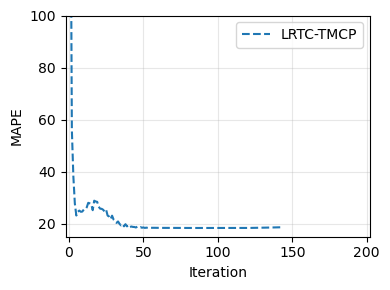

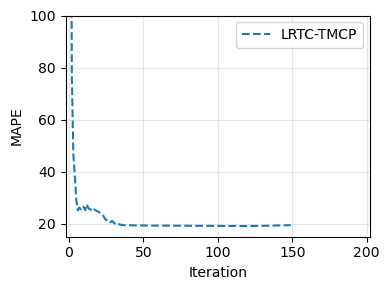

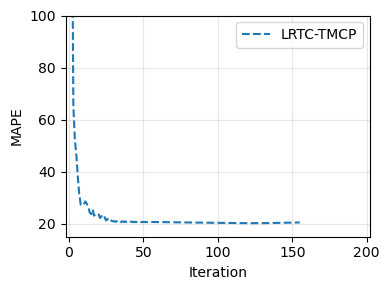

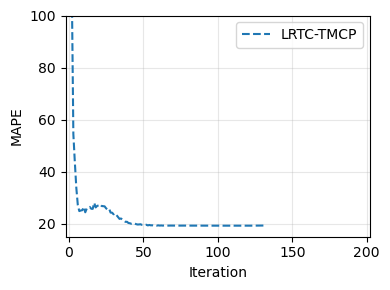

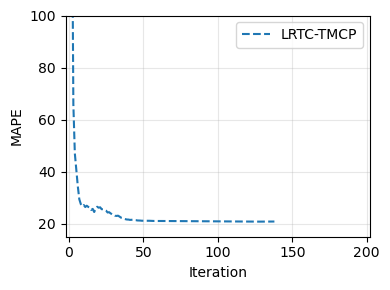

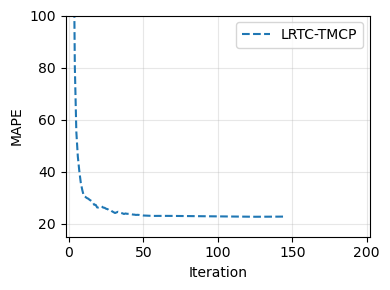

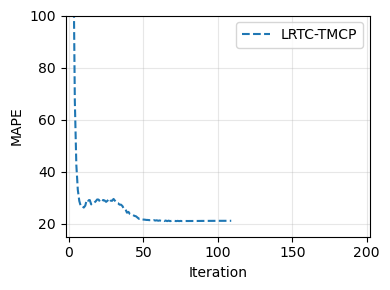

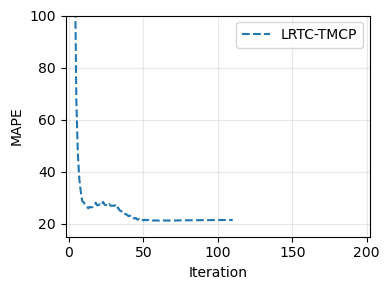

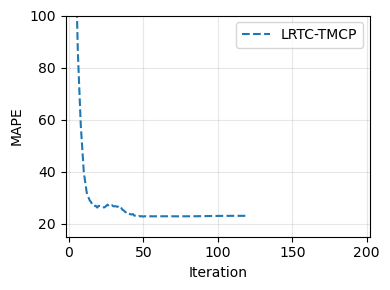

In [5]:
datasets = ["Hangzhou"]

for dataset_name in datasets:
    for kind in ["random", "non-random", "blackout"]:
        logger_dir = f"tmcp_{kind}_{dataset_name}"
        logging_save_dir = os.path.join(save_dir, logger_dir)
        # log the iteration results
        if not os.path.exists(logging_save_dir):
            os.makedirs(logging_save_dir)

        initial_rho = 1e-5
        theta0, beta, gamma = hyper_parameters[dataset_name][kind]
        for missing_rate in missing_rates[kind]:
            logger_info(logger_dir, log_path=os.path.join(logging_save_dir, f"completion_results.log"))
            result_logger = logging.getLogger(logger_dir)
            
            result_logger.info("--------------------------------------------------------------------------------------------------------")
            result_logger.info(f"ms: {missing_rate} \t initial rho: {initial_rho} \t theta0: {theta0} \t beta: {beta} \t gamma: {gamma}.")
            dense_tensor = load_data(dataset_name, dataroot)

            if kind == "blackout":
                if dataset_name in ["Seattle", "PeMS"]:
                    block_window = 12
                elif dataset_name in ["Hangzhou", "Portland"]:
                    block_window = 6
                binary_tensor, binary_blocks = missing_pattern(dense_tensor, missing_rate, kind=kind, block_window=block_window)
            else:
                binary_tensor = missing_pattern(dense_tensor, missing_rate, kind=kind)
            
            sparse_tensor = dense_tensor * binary_tensor
            pos_test = torch.where((dense_tensor != 0) & (sparse_tensor == 0))
            pos_missing = torch.where(sparse_tensor == 0)[0]
            theta = theta0 * np.exp(-beta * len(pos_missing) / (dense_tensor.shape[0] * dense_tensor.shape[1] * dense_tensor.shape[2]))

            M, RMSE, MAPE, used_time = recover_data(
                sparse_tensor, dense_tensor, pos_test, # data and test mask
                initial_rho, theta, gamma, # algorithm parameters
                logger=result_logger, # logger
                )
            
            fig = plt.figure(figsize=(4, 3))
            plt.grid(alpha=0.3)
            plt.plot(MAPE, "--", label="LRTC-TMCP")
            plt.xlabel("Iteration")
            plt.ylabel("MAPE")
            plt.legend()
            plt.axis([-2, 202, 15, 100])
            plt.tight_layout()
            plt.savefig(os.path.join(logging_save_dir, f"missing_rate_{missing_rate}_MAPE.png"), dpi=300, transparent=True)

        logger_close(result_logger)     # close the logger file